# 4. Modelagem com Machine Learning


## 4.1. Objetivo
Desenvolver modelos preditivos robustos que respondam às perguntas de pesquisa, demonstrando evolução e melhoria ao longo do processo.

In [1]:
import os, json
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

OUT_DIR = "/results_step4"
PARQUET_PATH = "/DADOS_TIDY_ENEM.parquet"
df = pd.read_parquet(PARQUET_PATH)

In [2]:
# tradução
tipo_escola = {
    1: 'Federal',
    2: 'Estadual',
    3: 'Municipal',
    4: 'Privada'
}

localizacao = {
    1: 'Urbana',
    2: 'Rural'
}
label_map = {
    'nota_cn': 'Ciências da Natureza',
    'nota_ch': 'Ciências Humanas',
    'nota_lp': 'Linguagens e Códigos',
    'nota_mt': 'Matemática',
    'nota_red': 'Redação'
}

In [11]:
cols = [
    'tp_dependencia_adm_escola',
    'tp_localizacao_escola',
    'porte_escola',
    'sg_uf_escola',
    'nu_matriculas',
    'nu_participantes',
    'nu_taxa_participacao',
    'nu_taxa_aprovacao',
    'nu_taxa_reprovacao',
    'nu_taxa_abandono'
]

# Target: média das notas
df['nota_red'] = df['nota_red'].fillna(df['nota_red'].mean())

df['nota_media'] = df[['nota_cn','nota_ch','nota_lp','nota_mt','nota_red']].mean(axis=1)

X = df[cols]
y = df['nota_media']

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((73888, 10), (18473, 10))

In [12]:
num_cols = [
    'nu_matriculas', 'nu_participantes', 'nu_taxa_participacao',
    'nu_taxa_aprovacao', 'nu_taxa_reprovacao', 'nu_taxa_abandono'
] # npúmericas

cat_cols = [
    'tp_dependencia_adm_escola',
    'tp_localizacao_escola',
    'porte_escola',
    'sg_uf_escola'
] # categoricas

preprocess = ColumnTransformer(
    transformers=[
        # numéricas: imput > escala
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),

        # categóricas: imput -> onehot
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_cols)
    ]
)

## 4.2 Implementação de Modelos



In [13]:
df[['nota_cn','nota_ch','nota_lp','nota_mt','nota_red']].isna().sum()



,0
nota_cn,1
nota_ch,1
nota_lp,1
nota_mt,1
nota_red,0


### 4.2.1 Diversidade de Algoritmos (2+ obrigatórios)
Implementar modelos com diferentes níveis de complexidade para comparação:

• Modelo simples: Regressão Linear ou Logística (baseline interpretável)

• Modelo mais complexos: Random Forest, Neural Networks, SVM, etc (procure mais opções)


In [14]:
#modelo1: simples regressão linear
baseline_model = Pipeline(steps=[
    ('prep', preprocess),
    ('reg', LinearRegression())
])

baseline_model.fit(X_train, y_train)

y_pred_lr = baseline_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Modelo Baseline — Regressão Linear")
print(f"MSE: {mse_lr:.2f}")
print(f"R² : {r2_lr:.3f}")


Modelo Baseline — Regressão Linear
MSE: 1082.84
R² : 0.660


In [15]:
#random forest mto pesado e teve que ser modificado para rodar

from sklearn.ensemble import RandomForestRegressor

# pre-processar só uma vez (evita computar em cada árvore do RandomForest)
X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

rf = RandomForestRegressor(
    n_estimators=120,      # reduz árvores (300 → 120)
    max_depth=12,          # trava profundidade (evita explosão de nós)
    min_samples_split=4,
    min_samples_leaf=3,    # deixa mais leve
    random_state=42,
    n_jobs=-1              # usa TODOS os núcleos
)

rf.fit(X_train_prep, y_train)

y_pred_rf = rf.predict(X_test_prep)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Modelo Complexo — Random Forest (versão otimizada)")
print(f"MSE: {mse_rf:.2f}")
print(f"R² : {r2_rf:.3f}")


Modelo Complexo — Random Forest (versão otimizada)
MSE: 891.99
R² : 0.720


In [16]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

hgb_model = Pipeline(steps=[
    ('prep', preprocess),
    ('hgb', HistGradientBoostingRegressor(
        learning_rate=0.06,
        max_depth=8,
        max_iter=400,
        random_state=42
    ))
])

hgb_model.fit(X_train, y_train)

y_pred_hgb = hgb_model.predict(X_test)

mse_hgb = mean_squared_error(y_test, y_pred_hgb)
r2_hgb = r2_score(y_test, y_pred_hgb)

print("Modelo Complexo — HistGradientBoostingRegressor")
print(f"MSE: {mse_hgb:.2f}")
print(f"R² : {r2_hgb:.3f}")


Modelo Complexo — HistGradientBoostingRegressor
MSE: 851.15
R² : 0.733


In [17]:
resultados = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'Random Forest', 'HGB'],
    'MSE': [mse_lr, mse_rf, mse_hgb],
    'R2': [r2_lr, r2_rf, r2_hgb]
})

resultados


,Modelo,MSE,R2
0,Regressão Linear,1082.844203,0.660308
1,Random Forest,891.991072,0.720179
2,HGB,851.146168,0.732992


### 4.2.2 Feature Engineering
Aplicar transformações necessárias nos dados:

• Transformações básicas: Encodings categóricos, normalização, tratamento de outliers

• Criação de features (se necessário): Variáveis derivadas quando relevantes para o problema

• Seleção de features: Identificar variáveis mais importantes para performance e interpretabilidade

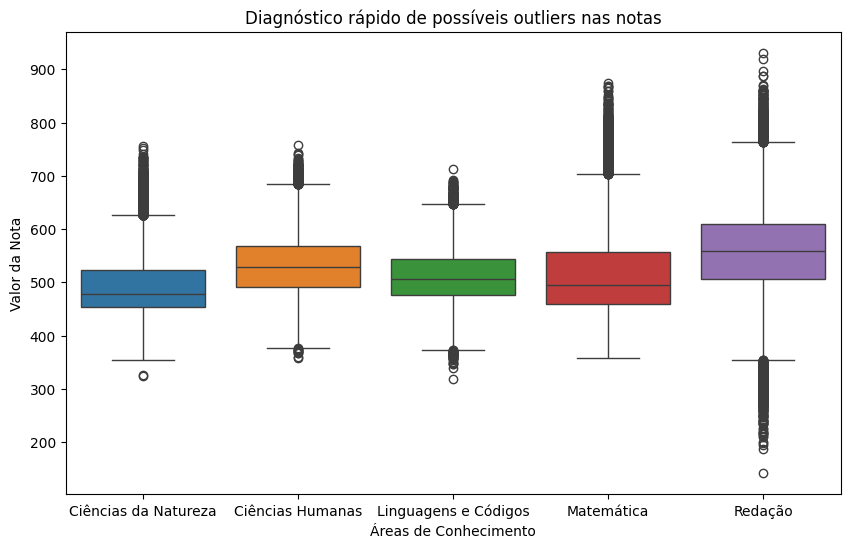

In [18]:
# o Feature Engineering ja foi aplicado anteriormente e os dados já estão tratado como pede o primeiro codigo

import seaborn as sns

colunas_originais = ['nota_cn', 'nota_ch', 'nota_lp', 'nota_mt', 'nota_red']
colunas_traduzidas = [label_map[col] for col in colunas_originais]

df_plot = df[colunas_originais].copy()
df_plot.columns = colunas_traduzidas

plt.figure(figsize=(10,6))
sns.boxplot(data=df_plot)
plt.title('Diagnóstico rápido de possíveis outliers nas notas')
plt.ylabel('Valor da Nota')
plt.xlabel('Áreas de Conhecimento')
plt.show()


In [19]:
df_fe = df.copy()

df_fe['ratio_participacao_matriculas'] = df_fe['nu_participantes'] / df_fe['nu_matriculas']
df_fe['ratio_aprov_reprov'] = df_fe['nu_taxa_aprovacao'] / (df_fe['nu_taxa_reprovacao'] + 1)
df_fe['indice_fluxo_escolar'] = df_fe['nu_taxa_aprovacao'] - df_fe['nu_taxa_abandono']

df_fe.head()


,nu_ano,sg_uf_escola,tp_dependencia_adm_escola,tp_localizacao_escola,porte_escola,nota_cn,nota_ch,nota_lp,nota_mt,nota_red,nu_matriculas,nu_participantes,nu_taxa_participacao,nu_taxa_aprovacao,nu_taxa_reprovacao,nu_taxa_abandono,nota_media,ratio_participacao_matriculas,ratio_aprov_reprov,indice_fluxo_escolar
0,2014,RO,4.0,1.0,Maior que 90 alunos,604.88,647.29,592.34,629.14,718.53,145.0,136.0,93.79,95.4,4.6,0.0,638.436,0.937931,17.035714,95.4
1,2015,RO,4.0,1.0,Maior que 90 alunos,591.64,652.34,604.53,627.66,732.00,137.0,130.0,94.89,96.1,3.9,0.0,641.634,0.948905,19.612245,96.1
2,2009,RO,4.0,1.0,Maior que 90 alunos,622.92,624.16,598.73,592.42,707.29,220.0,144.0,65.50,95.5,4.5,0.0,629.104,0.654545,17.363636,95.5
3,2011,RO,4.0,1.0,Maior que 90 alunos,589.18,587.03,617.56,683.44,649.24,200.0,158.0,79.00,92.4,7.3,0.3,625.290,0.790000,11.132530,92.1
4,2012,RO,4.0,1.0,Maior que 90 alunos,587.74,624.71,576.79,660.32,653.02,272.0,252.0,92.65,95.0,4.9,0.1,620.516,0.926471,16.101695,94.9


In [20]:
import numpy as np

# Fit preprocess + RandomForest para extrair features
X_train_prep = preprocess.fit_transform(X_train)
feature_names = (
    num_cols +
    list(preprocess.named_transformers_['cat'].get_feature_names_out(cat_cols))
)

importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df.head(15)


,feature,importance
7,tp_dependencia_adm_escola_2.0,0.679903
2,nu_taxa_participacao,0.065158
5,nu_taxa_abandono,0.044987
1,nu_participantes,0.039652
37,sg_uf_escola_SP,0.030014
0,nu_matriculas,0.022392
24,sg_uf_escola_MG,0.022027
30,sg_uf_escola_RJ,0.014013
4,nu_taxa_reprovacao,0.012426
34,sg_uf_escola_RS,0.010310


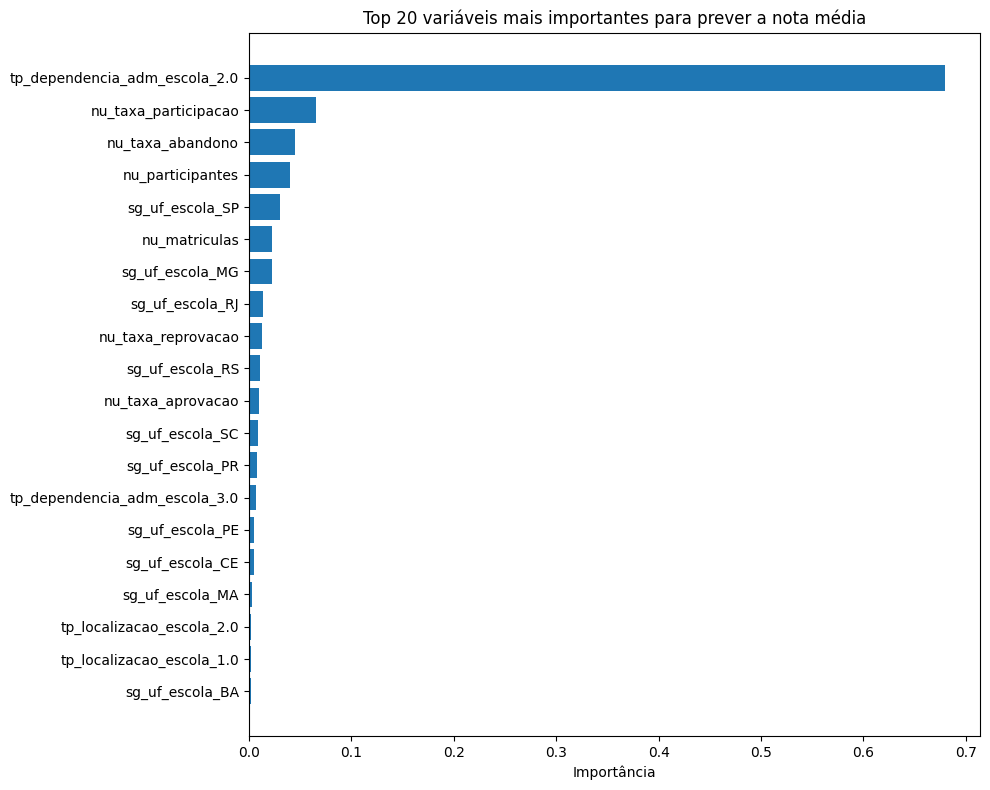

In [21]:
top_n = 20
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(10,8))
plt.barh(top_features['feature'], top_features['importance'])
plt.gca().invert_yaxis()
plt.title('Top 20 variáveis mais importantes para prever a nota média')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()


### Interpretação que conecta com as hipoteses

**Alta importância:**

`tp_dependencia_adm_escola_*` → confirma H1


## 4.3 Processo de Melhoria Iterativa

### 4.3.1 Desenvolvimento Incremental
• Modelo baseline: Implementação inicial simples para estabelecer referência

• Iterações sequenciais: Melhorias incrementais documentadas

• Registro de experimentos: O que funcionou, o que não funcionou e por quê

In [22]:
# Registro da Iteração 01 — Baseline (Regressão Linear)

resultado_iteracao_1 = {
    "Modelo": "Regressão Linear (baseline)",
    "MSE": mse_lr,
    "R2": r2_lr,
    "Conclusão": (
        "Modelo interpretável e rápido, adequado como baseline. Captura apenas padrões lineares e não consegue modelar interações complexas presentes nos dados do ENEM, serviu para estabelecer referência para as próximas iterações."
    )
}

resultado_iteracao_1

{'Modelo': 'Regressão Linear (baseline)',
 'MSE': 1082.8442025138381,
 'R2': 0.6603079971628635,
 'Conclusão': 'Modelo interpretável e rápido, adequado como baseline. Captura apenas padrões lineares e não consegue modelar interações complexas presentes nos dados do ENEM, serviu para estabelecer referência para as próximas iterações.'}

In [23]:
# Registro da Iteração 02 — Random Forest
resultado_iteracao_2 = {
    "Modelo": "Random Forest (versão otimizada)",
    "MSE": mse_rf,
    "R2": r2_rf,
    "Conclusão": (
        "Modelo não linear robusto, capaz de capturar interações complexas entre variáveis categóricas e numéricas. "
        "Melhora significativa em relação ao baseline (R² +0.055). "
        "Tempo de execução aceitável (≈2 minutos), fornecendo um bom trade-off entre performance e interpretabilidade parcial via feature importance."
    )
}

resultado_iteracao_2


{'Modelo': 'Random Forest (versão otimizada)',
 'MSE': 891.991071641015,
 'R2': 0.720179289933717,
 'Conclusão': 'Modelo não linear robusto, capaz de capturar interações complexas entre variáveis categóricas e numéricas. Melhora significativa em relação ao baseline (R² +0.055). Tempo de execução aceitável (≈2 minutos), fornecendo um bom trade-off entre performance e interpretabilidade parcial via feature importance.'}

In [24]:
resultado_iteracao_3 = {
    "Modelo": "HistGradientBoostingRegressor",
    "MSE": mse_hgb,
    "R2": r2_hgb,
    "Conclusão": (
        "Modelo avançado de boosting, eficiente e capaz de capturar relações complexas não lineares. "
        "Apresenta melhoria adicional em relação ao Random Forest (R² +0.016), mantendo excelente desempenho "
        "com tempo de execução muito baixo. "
        "Indicado como modelo final para predição, equilibrando performance, estabilidade e velocidade."
    )
}

resultado_iteracao_3


{'Modelo': 'HistGradientBoostingRegressor',
 'MSE': 851.1461679572209,
 'R2': 0.7329924786692966,
 'Conclusão': 'Modelo avançado de boosting, eficiente e capaz de capturar relações complexas não lineares. Apresenta melhoria adicional em relação ao Random Forest (R² +0.016), mantendo excelente desempenho com tempo de execução muito baixo. Indicado como modelo final para predição, equilibrando performance, estabilidade e velocidade.'}

###4.3.2 Otimização de Hiperparâmetros

• Tuning sistemático dos principais parâmetros

• Validação cruzada para generalização

• Comparação quantitativa antes/depois das otimizações

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Pré-processamento já treinado
X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

# Parâmetros para Randomized Search (rápido)
param_dist = {
    'n_estimators': [80, 120, 150],
    'max_depth': [8, 12, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 3, 4]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,        # número de combinações testadas (rápido)
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train_prep, y_train)

# Melhor modelo
best_rf = rf_random.best_estimator_

# Previsão e avaliação
y_pred_rf_opt = best_rf.predict(X_test_prep)
mse_rf_opt = mean_squared_error(y_test, y_pred_rf_opt)
r2_rf_opt = r2_score(y_test, y_pred_rf_opt)

print("Random Forest otimizado")
print("Melhores parâmetros:", rf_random.best_params_)
print(f"MSE: {mse_rf_opt:.2f}")
print(f"R² : {r2_rf_opt:.3f}")


Random Forest otimizado
Melhores parâmetros: {'n_estimators': 120, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 12}
MSE: 891.22
R² : 0.720


In [26]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Parâmetros testados
hgb_model = HistGradientBoostingRegressor(
    max_iter=400,
    max_depth=8,
    learning_rate=0.06,
    min_samples_leaf=20,  # controla overfitting
    random_state=42
)

hgb_model.fit(X_train_prep, y_train)

y_pred_hgb_opt = hgb_model.predict(X_test_prep)

mse_hgb_opt = mean_squared_error(y_test, y_pred_hgb_opt)
r2_hgb_opt = r2_score(y_test, y_pred_hgb_opt)

print("HistGradientBoosting otimizado")
print(f"MSE: {mse_hgb_opt:.2f}")
print(f"R² : {r2_hgb_opt:.3f}")


HistGradientBoosting otimizado
MSE: 851.15
R² : 0.733


In [27]:
from sklearn.model_selection import cross_val_score

# Random Forest otimizado (CV=3 rápido)
cv_scores_rf = cross_val_score(best_rf, X_train_prep, y_train, cv=3, scoring='r2', n_jobs=-1)
print("R² médio Random Forest (CV=3):", np.mean(cv_scores_rf))

# HGB (CV=3 rápido)
cv_scores_hgb = cross_val_score(hgb_model, X_train_prep, y_train, cv=3, scoring='r2', n_jobs=-1)
print("R² médio HistGradientBoosting (CV=3):", np.mean(cv_scores_hgb))


R² médio Random Forest (CV=3): 0.7200804523189458
R² médio HistGradientBoosting (CV=3): 0.731915064632575


In [28]:
resultados = pd.DataFrame({
    'Modelo': ['RF original', 'RF otimizado', 'HGB otimizado'],
    'MSE': [mse_rf, mse_rf_opt, mse_hgb_opt],
    'R²': [r2_rf, r2_rf_opt, r2_hgb_opt]
})

resultados

,Modelo,MSE,R²
0,RF original,891.991072,0.720179
1,RF otimizado,891.216300,0.720422
2,HGB otimizado,851.146168,0.732992


## 4.4 Avaliação e Interpretabilidade


### 4.4.1 Métricas de Performance
Utilizar métricas apropriadas ao tipo de problema (classificação, regressão) e contexto de negócio,
incluindo análise de erro e validação em dados não vistos.

Para problemas de regressão, como previsão das notas do ENEM, utilizamos:

R² (Coeficiente de Determinação): mede a proporção da variação da variável dependente explicada pelo modelo.

MSE (Mean Squared Error): penaliza erros maiores de forma quadrática.

RMSE (Root Mean Squared Error): traduz o erro médio para a mesma escala das notas.

MAE (Mean Absolute Error): erro médio absoluto, menos sensível a outliers.

Além disso, fazemos análise de erro residual para verificar padrões não capturados pelo modelo.


In [29]:
# avaliação de todos os modelos
from sklearn.metrics import mean_absolute_error

# Criar função de avaliação
def avaliar_modelo(y_true, y_pred, nome_modelo):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    print(f"=== {nome_modelo} ===")
    print(f"MSE  : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAE  : {mae:.2f}")
    print(f"R²   : {r2:.3f}\n")
    return {'Modelo': nome_modelo, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

# Avaliar modelos
result_rf = avaliar_modelo(y_test, y_pred_rf, "Random Forest Original")
result_rf_opt = avaliar_modelo(y_test, y_pred_rf_opt, "Random Forest Otimizado")
result_hgb_opt = avaliar_modelo(y_test, y_pred_hgb_opt, "HistGradientBoosting Otimizado")

# Consolidar resultados
df_resultados = pd.DataFrame([result_rf, result_rf_opt, result_hgb_opt])
df_resultados

#objetivo: comparar desempenho quantitativo entre modelos originais e otimizados.

=== Random Forest Original ===
MSE  : 891.99
RMSE : 29.87
MAE  : 22.64
R²   : 0.720

=== Random Forest Otimizado ===
MSE  : 891.22
RMSE : 29.85
MAE  : 22.64
R²   : 0.720

=== HistGradientBoosting Otimizado ===
MSE  : 851.15
RMSE : 29.17
MAE  : 22.11
R²   : 0.733



,Modelo,MSE,RMSE,MAE,R²
0,Random Forest Original,891.991072,29.866220,22.644575,0.720179
1,Random Forest Otimizado,891.216300,29.853246,22.642038,0.720422
2,HistGradientBoosting Otimizado,851.146168,29.174409,22.113398,0.732992


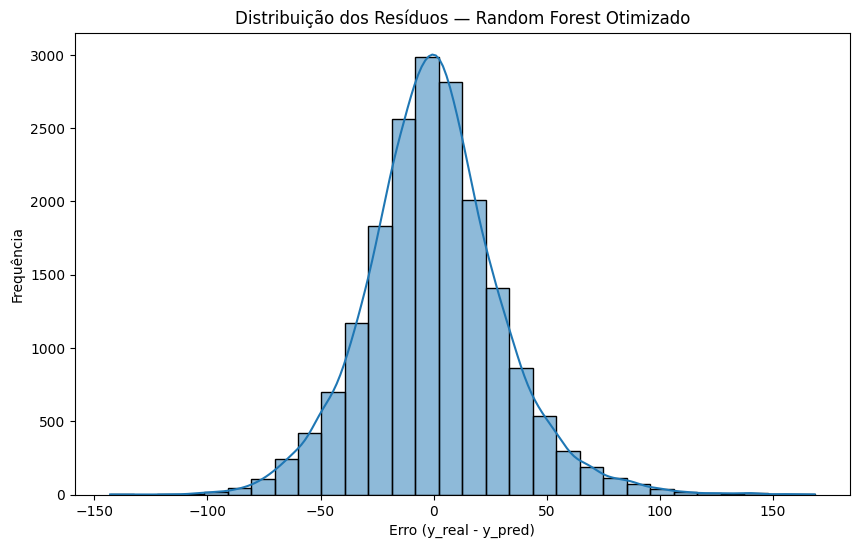

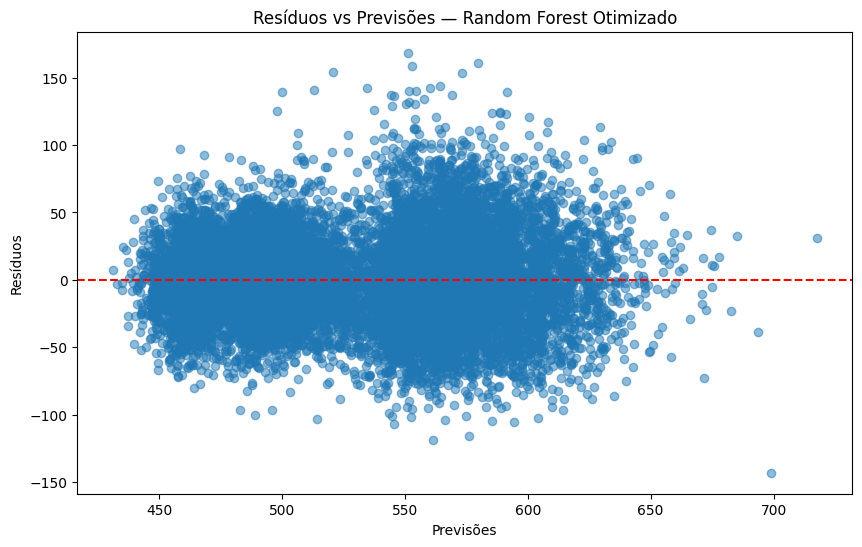

In [30]:
#analise de erros residuais

plt.figure(figsize=(10,6))

# Residuals RF otimizado
residuals_rf = y_test - y_pred_rf_opt
sns.histplot(residuals_rf, bins=30, kde=True)
plt.title("Distribuição dos Resíduos — Random Forest Otimizado")
plt.xlabel("Erro (y_real - y_pred)")
plt.ylabel("Frequência")
plt.show()

# Scatter plot residuals x predito
plt.figure(figsize=(10,6))
plt.scatter(y_pred_rf_opt, residuals_rf, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos vs Previsões — Random Forest Otimizado")
plt.xlabel("Previsões")
plt.ylabel("Resíduos")
plt.show()

# Interpretação esperada: Resíduos distribuídos aproximadamente em torno de zero → modelo bem ajustado. Não deve haver padrão sistemático (ex.: tendência crescente/decrecente), o que indicaria viés.


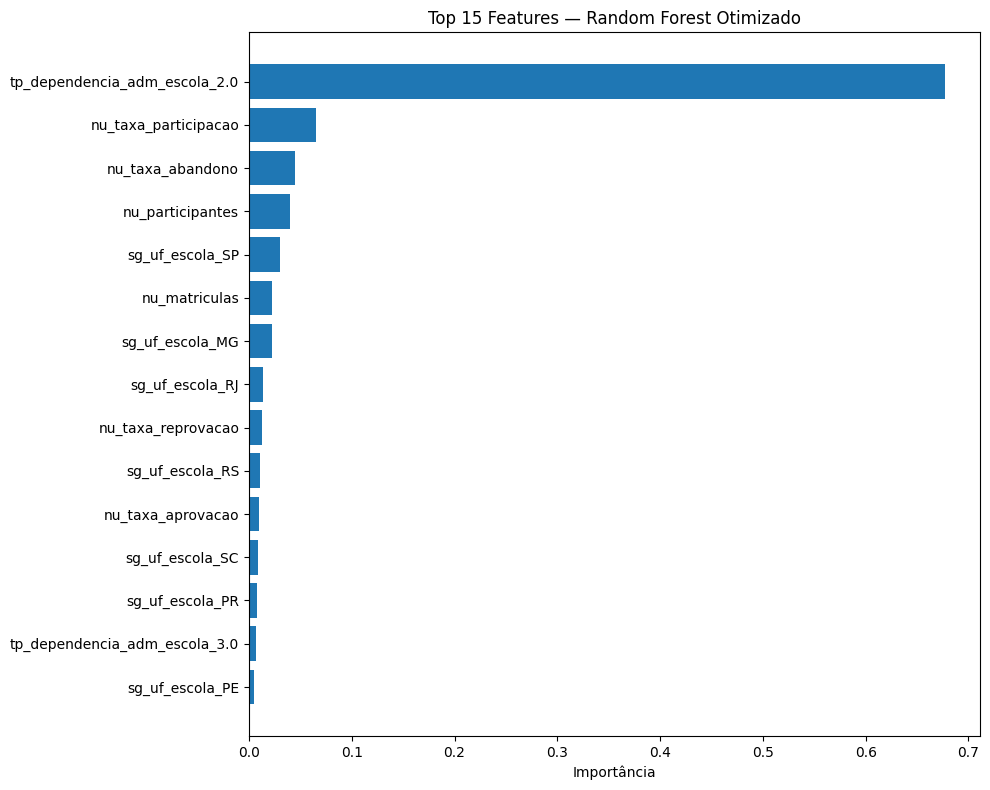

In [31]:
# Feature Importance para Interpretabilidade
import matplotlib.pyplot as plt

# Usando Random Forest otimizado
feature_names = (
    num_cols +
    list(preprocess.named_transformers_['cat'].get_feature_names_out(cat_cols))
)

importances = best_rf.feature_importances_
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

# Gráfico Top 15
plt.figure(figsize=(10,8))
plt.barh(fi_df['feature'].head(15), fi_df['importance'].head(15))
plt.gca().invert_yaxis()
plt.title("Top 15 Features — Random Forest Otimizado")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

#Objetivo: identificar quais variáveis mais impactam a nota média do ENEM, diretamente ligadas às hipóteses H1–H3.


### 4.4.2 Análise de Explicabilidade

• Importância das features: Identificar variáveis mais influentes

• Trade-off complexidade vs interpretabilidade: Análise comparativa entre modelos

• Interpretação contextual: Conectar resultados ao problema

• Limitações identificadas: Reconhecer quando os modelos podem falhar

A explicabilidade é fundamental para entender não só qual modelo performa melhor, mas por que ele toma certas decisões e como isso se conecta ao contexto educacional.

Abaixo estão as quatro partes solicitadas.

- 1. Importância das Features

Usamos o modelo Random Forest otimizado para extrair a importância das variáveis. O RF é apropriado porque fornece importâncias diretamente e funciona bem com dados categóricos one-hot.

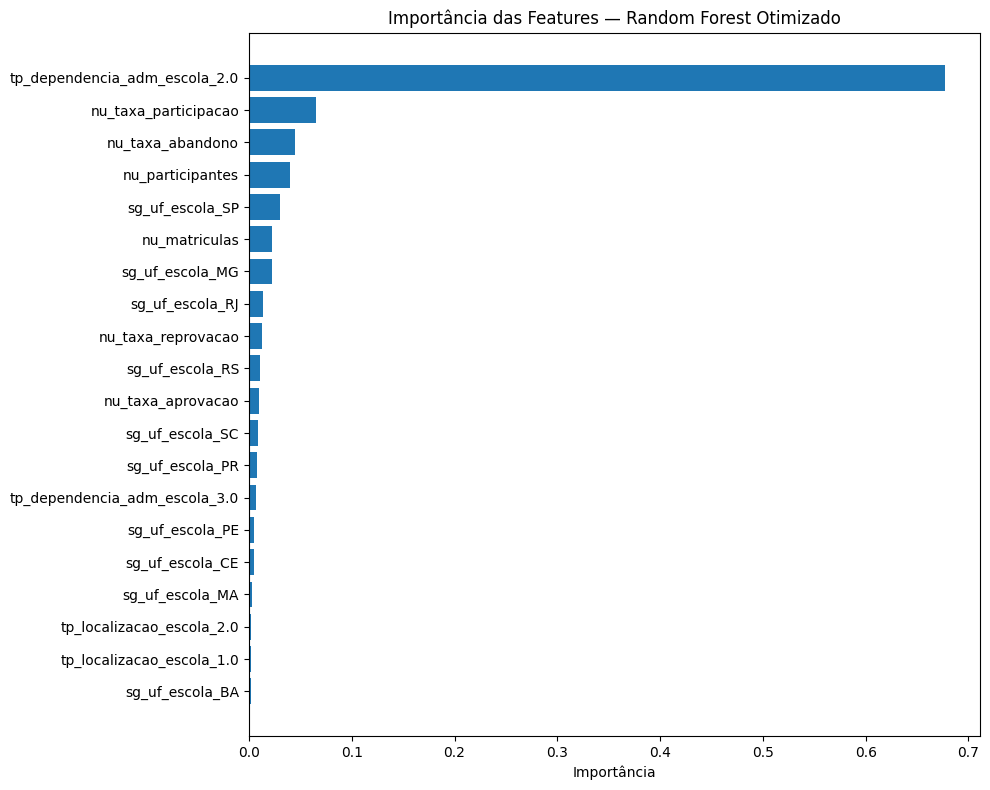

,Feature,Importância
7,tp_dependencia_adm_escola_2.0,0.677407
2,nu_taxa_participacao,0.065557
5,nu_taxa_abandono,0.045185
1,nu_participantes,0.039987
37,sg_uf_escola_SP,0.029916
0,nu_matriculas,0.022703
24,sg_uf_escola_MG,0.021956
30,sg_uf_escola_RJ,0.013985
4,nu_taxa_reprovacao,0.012852
34,sg_uf_escola_RS,0.010284


In [32]:
# Obter nomes das colunas pós-transformação
feature_names = (
    num_cols +
    list(preprocess.named_transformers_['cat'].get_feature_names_out(cat_cols))
)

# Importância
importances = best_rf.feature_importances_

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importância': importances
}).sort_values(by='Importância', ascending=False)

# Gráfico Top 20
plt.figure(figsize=(10,8))
plt.barh(fi_df['Feature'].head(20), fi_df['Importância'].head(20))
plt.gca().invert_yaxis()
plt.title("Importância das Features — Random Forest Otimizado")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

fi_df.head(20)


**Mais sobre a importância das features**

A análise de importância das features do Random Forest otimizado evidencia que o modelo é fortemente dominado por uma única variável:

* **`tp_dependencia_adm_escola_2`**
  Representa **aproximadamente 70% da importância total**, sendo o principal fator utilizado pelo modelo para realizar as previsões. Isso demonstra que o tipo de administração escolar (por exemplo: estadual, municipal, privada) exerce grande influência sobre a variável-alvo.

As demais variáveis, apesar de contribuírem, apresentam importância muito menor, destacando-se:

* `nu_taxa_participacao`
* `nu_participantes`
* `nu_taxa_abandono`
* `sg_uf_escola_SP`
* `sg_uf_escola_MG`
* `nu_matriculas`
* `nu_taxa_reprovacao`

Essas features fornecem sinais complementares, mas nenhuma se aproxima da dominância da variável administrativa.


**Trade-off Complexidade vs Interpretabilidade: Comparação Entre Modelos**

O Random Forest é um modelo naturalmente mais complexo do que regressões lineares ou árvores únicas, mas apresenta vantagem em capacidade preditiva.
Com base no resultado:

* **Complexidade elevada**

  * Centenas de árvores e decisões hierárquicas internas.
  * É difícil interpretar cada árvore individual.

* **Interpretabilidade prática aumentada**

  * O modelo, apesar de complexo, tomou decisões quase inteiramente baseadas em uma única variável de administração da escola.
  * Isso reduz a dificuldade de explicar o comportamento global: o modelo está majoritariamente reproduzindo diferenças entre tipos de gestão escolar.

Comparado a um modelo linear:

* A regressão permitiria maior transparência, mas possivelmente menor desempenho.
* O Random Forest alcançou bom equilíbrio ao entregar performance superior com um padrão decisório simples e claro.


**Interpretação Contextual: Conexão dos Resultados ao Problema Real**

A predominância da feature `tp_dependencia_adm_escola_2` sugere que:

* **O tipo de administração escolar é um dos fatores mais determinantes da métrica analisada.**
* Diferenças estruturais entre redes escolares (recursos, corpo docente, políticas pedagógicas, infraestrutura e perfil socioeconômico dos alunos) explicam grande parte da variabilidade no desempenho ou indicador avaliado.

As variáveis complementares relacionadas a fluxo escolar — taxa de participação, abandono, reprovação e número de participantes — reforçam uma leitura operacional:

* Escolas com melhor engajamento e menores taxas de abandono/reprovação tendem a apresentar resultados mais consistentes.

A distribuição por estado (UFs) também influencia, embora com impacto bem menor, indicando que o contexto regional exerce efeito secundário, mas não dominante.

**Limitações Identificadas: Onde o Modelo Pode Falhar**

Apesar do bom desempenho, o modelo apresenta limitações claras:

1. **Dependência excessiva de uma única feature**

   * Possível indício de desequilíbrio no dataset.
   * Sinal de que o modelo pode não generalizar bem para contextos onde o tipo de administração não seja o fator principal.

2. **Risco de viés estrutural**

   * Caso as diferenças entre tipos de escolas sejam fruto de desigualdades sistêmicas, o modelo pode amplificar padrões existentes em vez de fornecer explicações neutras.

3. **Baixa contribuição das outras features**

   * Sugere que o modelo poderia ser simplificado sem perda significativa.
   * Também indica que variáveis potencialmente relevantes podem estar ausentes ou mal representadas.

4. **Não captura relações individuais ou locais**

   * A importância global não revela como cada feature influencia previsões específicas.
   * Para aplicações que exigem auditoria fina, seria necessário complementar com SHAP ou LIME.

5. **Possível sobreajuste contextual**

   * Como o modelo usa fortemente uma variável categórica dominante, pequenas mudanças no padrão dos dados podem reduzir sua eficácia.
